<a href="https://colab.research.google.com/github/benjaminnigjeh/VAEMS/blob/main/FCVAE_updated_20240829.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and dependencies

Deep learning is performed by using tensorfolw and keras as frontend and backend, respectively. The datasets are prepared by using numpy and pandas libraries.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from google.colab import files

# Set up the tensorboard callback function

In [2]:
NAME = "Unsupervised_clustering"
tensorboard = TensorBoard(
    log_dir='/content/{}'.format(NAME))

# Upload dataset from a local folder

the number of features is equal to n_dim squared.

The dataset is generated from an earlier study (https://aacrjournals.org/cancerrescommun/article/2/6/434/704876/Proteome-Analysis-of-Pancreatic-Tumors-Implicates).

This dataset quantified 50 cancer tissue versus 5 healthy controls. 7698 proteins were quantifed from each tissue.

In [3]:
n_dim = 88
dataset = files.upload_file('dataset')
df = pd.read_csv('/content/dataset')
X = df.copy()
Y = X.pop("target")
X_np = np.array(X)
x_train = np.reshape(X_np,(-1, n_dim, n_dim, 1))
y_train = np.array(Y)


Saved pancreatic_tissue (1).csv to /content/dataset


# Define the n dimensions for the latent space

In [4]:
latent_dim = 2

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder and decoder architure and VAE class

In [5]:
encoder_inputs = keras.Input(shape=(n_dim, n_dim, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(120 , activation="relu")(x)
x = layers.Dense(120 , activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(n_dim * n_dim * 1, activation="relu")(latent_inputs)
x = layers.Dense(n_dim * n_dim * 1, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((n_dim, n_dim, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 88, 88, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 7744)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 120)            │        929,400 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 120)            │         14,520 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │          1,936 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 945,924 (3.61 MB)

 Trainable params: 945,924 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7744)                │          23,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7744)                │      59,977,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 88, 88, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,000,512 (228.88 MB)

 Trainable params: 60,000,512 (228.88 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - kl_loss: 8.1980 - loss: 4794.8877 - reconstruction_loss: 4786.6899
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - kl_loss: 6.9065 - loss: 4775.2974 - reconstruction_loss: 4768.3911
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - kl_loss: 9.0208 - loss: 4770.9683 - reconstruction_loss: 4761.9473
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - kl_loss: 8.4789 - loss: 4760.7944 - reconstruction_loss: 4752.3159
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - kl_loss: 7.2053 - loss: 4755.0669 - reconstruction_loss: 4747.8618
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


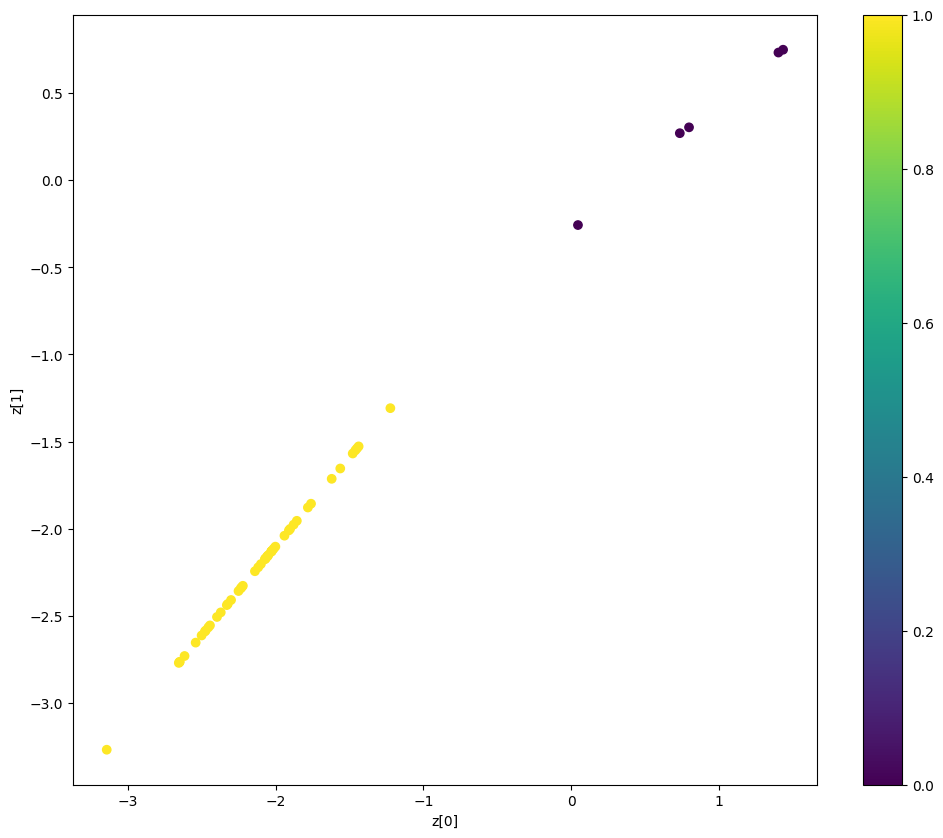

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=5, callbacks=[tensorboard])

def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_train, y_train)

# Estimation of euclidian distance in the binary clusters

In [13]:
data = []
length = len(y_train)

for i in range(0, length, 1):
    b = np.reshape(x_train[i], (1, n_dim, n_dim, 1))
    z_mean, _, _ = vae.encoder.predict(b)
    c = np.array([[z_mean[:, 0], z_mean[:, 1]]])
    c = np.reshape(c, (2, 1))
    c = np.transpose(c)
    data.append(c)

data = np.array(data)
data = np.reshape(data, (length, 2))
y_train_label = np.reshape(y_train, (length, 1))
data = np.concatenate((data, y_train_label), axis=1)
means_cluster_1 = data[0:int(length/2), :2].mean(axis=0)
means_cluster_2 = data[int(length/2):length+1, :2].mean(axis=0)
dist = np.linalg.norm(means_cluster_1-means_cluster_2)
print("Euclidian distance is ", dist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━